# Integration: MARIO and MaxFuse

This notebook performs cross-modal integration using:
1. MARIO - Matchability testing and bipartite matching
2. MaxFuse - Graph-based fuzzy smoothed embedding

**Prerequisites**: Run `preprocessing.ipynb` first

**Outputs**: Matching results saved to `../results/`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.io import mmread
from maxfuse import Fusor, Mario
from maxfuse.mario import pipelined_mario

import warnings
warnings.filterwarnings('ignore')

# Set plotting defaults
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 100
import json


In [2]:
# Load preprocessed data from 1_preprocessing.ipynb
# Run 1_preprocessing.ipynb first to generate these files

import os

results_dir = 'results/1_preprocessing'

if not os.path.exists(results_dir):
    raise FileNotFoundError(
        f"Results directory '{results_dir}' not found. "
        f"Run 1_preprocessing.ipynb first to generate the input files."
    )

# Load processed AnnData objects
protein_adata = sc.read_h5ad(f'{results_dir}/protein_adata.h5ad')
rna_adata = sc.read_h5ad(f'{results_dir}/rna_adata.h5ad')
rna_adata_lognorm = sc.read_h5ad(f'{results_dir}/rna_adata_lognorm.h5ad')

print(f"Loaded from {results_dir}/")
print(f"  Protein data: {protein_adata.shape}")
print(f"  RNA data: {rna_adata.shape}")
print(f"  RNA log-normalized: {rna_adata_lognorm.shape}")

# Load preprocessing parameters
with open(f'{results_dir}/preprocessing_params.json', 'r') as f:
    preprocess_params = json.load(f)
print(f"\nPreprocessing timestamp: {preprocess_params['timestamp']}")

Loaded from results/1_preprocessing/
  Protein data: (172181, 26)
  RNA data: (9374, 18626)
  RNA log-normalized: (9374, 18626)

Preprocessing timestamp: 2026-01-09T17:15:37.483901


## Step 3: Build Protein-Gene Correspondence

Map CODEX protein markers to their corresponding gene names in the RNA data.

In [3]:
# Load correspondence table
correspondence = pd.read_csv('data/protein_gene_conversion.csv', encoding='utf-8-sig')
print(f"Correspondence table: {correspondence.shape[0]} entries")
correspondence.head(10)

Correspondence table: 345 entries


,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG
5,CD275-1,ICOSLG
6,CD275-2,ICOSLG
7,CD11b,ITGAM
8,CD11b-1,ITGAM
9,CD11b-2,ITGAM


In [4]:
# Find matching features between CODEX markers and RNA genes
rna_protein_correspondence = []
unmatched_proteins = []

for marker in protein_adata.var_names:
    # Skip DAPI and ECAD (not useful for cell type matching)
    if marker in ['DAPI', 'ECAD']:
        continue
    
    # Look up in correspondence table
    matches = correspondence[correspondence['Protein name'].str.lower() == marker.lower()]
    
    if len(matches) == 0:
        # Try alternative names
        alt_names = {
            'CD3e': 'CD3',
            'FoxP3': 'FOXP3',
            'HLADR': 'HLA-DR',
            'Lyve1': 'LYVE1',
            'SMActin': 'aSMA',
            'CollagenIV': 'collagen IV',
        }
        alt_marker = alt_names.get(marker, marker)
        matches = correspondence[correspondence['Protein name'].str.lower() == alt_marker.lower()]
    
    if len(matches) > 0:
        rna_names_str = matches.iloc[0]['RNA name']
        if 'Ignore' in str(rna_names_str):
            unmatched_proteins.append((marker, 'Ignored'))
            continue
        
        # Try each RNA name option
        found = False
        for rna_name in str(rna_names_str).split('/'):
            if rna_name in rna_adata.var_names:
                rna_protein_correspondence.append([rna_name, marker])
                found = True
                break
        if not found:
            unmatched_proteins.append((marker, rna_names_str))
    else:
        unmatched_proteins.append((marker, 'Not in table'))

rna_protein_correspondence = np.array(rna_protein_correspondence)
print(f"Found {len(rna_protein_correspondence)} protein-gene pairs")

if unmatched_proteins:
    print(f"\nUnmatched proteins ({len(unmatched_proteins)}):")
    for prot, reason in unmatched_proteins:
        print(f"  {prot}: {reason}")

Found 24 protein-gene pairs


In [5]:
# Remove duplicates (same RNA mapping to multiple proteins)
# Keep first occurrence
seen_rna = set()
unique_pairs = []
for rna, prot in rna_protein_correspondence:
    if rna not in seen_rna:
        seen_rna.add(rna)
        unique_pairs.append([rna, prot])
    else:
        print(f"Removing duplicate RNA mapping: {rna} -> {prot}")

rna_protein_correspondence = np.array(unique_pairs)
print(f"\nFinal correspondence: {len(rna_protein_correspondence)} pairs")

print("\nMatched features:")
for rna, prot in rna_protein_correspondence:
    print(f"  {rna:15} <-> {prot}")

Removing duplicate RNA mapping: PTPRC -> CD45RO

Final correspondence: 23 pairs

Matched features:
  CD1C            <-> CD1c
  CD3E            <-> CD3e
  CD4             <-> CD4
  CD8A            <-> CD8
  ITGAX           <-> CD11c
  FUT4            <-> CD15
  MS4A1           <-> CD20
  CR2             <-> CD21
  PECAM1          <-> CD31
  CD34            <-> CD34
  CR1             <-> CD35
  CD44            <-> CD44
  PTPRC           <-> CD45
  CD68            <-> CD68
  LAMP1           <-> CD107a
  CD163           <-> CD163
  COL4A1          <-> CollagenIV
  FOXP3           <-> FoxP3
  HLA-DRA         <-> HLADR
  MKI67           <-> Ki67
  LYVE1           <-> Lyve1
  ACTA2           <-> SMActin
  VIM             <-> Vimentin


## Step 4: Prepare Arrays for Integration

Extract and normalize:
- **Shared arrays**: Corresponding protein/gene features (used for initial matching)
- **Active arrays**: All features (used for refinement)

In [6]:
# Extract shared features from FILTERED data
rna_shared_adata = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared_adata = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

print(f"rna_shared_adata: {rna_shared_adata.shape}")
print(f"protein_shared_adata: {protein_shared_adata.shape}")

rna_shared_adata: (9374, 23)
protein_shared_adata: (172181, 23)


In [7]:
# Normalize shared features - DETECTION-AWARE PIPELINE
# 
# Key insight: RNA (~9K cells) and Protein (~170K cells) have different cell counts.
# This causes the SAME biological "zero" to get different quantile values after
# rank normalization because the proportion of zeros differs.
#
# Solution: Detection-aware normalization
# 1. Transform each modality appropriately (log1p for RNA, arcsinh for protein)
# 2. For each feature, normalize NON-ZERO values separately to [0, 1] range
# 3. Set all zeros to a consistent negative value (e.g., -1 or the min of non-zeros)
# 4. This ensures zeros are treated equivalently regardless of how many exist

from scipy.stats import rankdata

# Store raw values before normalization
rna_shared_raw = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared_raw):
    rna_shared_raw = rna_shared_raw.toarray()
protein_shared_raw = protein_shared_adata.X.copy()
if sparse.issparse(protein_shared_raw):
    protein_shared_raw = protein_shared_raw.toarray()

print("=" * 70)
print("DETECTION-AWARE NORMALIZATION PIPELINE")
print("=" * 70)
print(f"\nCell counts: RNA = {rna_shared_raw.shape[0]:,}, Protein = {protein_shared_raw.shape[0]:,}")
print("\nProblem: Different cell counts cause different zero proportions,")
print("         leading to misaligned distributions after standard normalization.")
print("\nSolution: Normalize non-zero values separately, treat zeros consistently.")

# ============================================================
# STEP 1: MODALITY-SPECIFIC TRANSFORMATIONS
# ============================================================

print("\n" + "="*70)
print("STEP 1: Modality-specific transformations")
print("="*70)

# --- RNA: Standard scanpy pipeline ---
print("\nRNA transformation:")
print(f"  Raw - shape: {rna_shared_raw.shape}")
print(f"       mean: {rna_shared_raw.mean():.3f}, zeros: {(rna_shared_raw == 0).mean()*100:.1f}%")

# Library size normalization
sc.pp.normalize_total(rna_shared_adata, target_sum=1e4)
rna_after_norm = rna_shared_adata.X.copy()
if sparse.issparse(rna_after_norm):
    rna_after_norm = rna_after_norm.toarray()

# Log1p transformation
sc.pp.log1p(rna_shared_adata)
rna_after_log = rna_shared_adata.X.copy()
if sparse.issparse(rna_after_log):
    rna_after_log = rna_after_log.toarray()
print(f"  After normalize_total + log1p - mean: {rna_after_log.mean():.3f}")

# --- Protein: Arcsinh transformation (standard for cytometry) ---
print("\nProtein transformation (arcsinh with cofactor=5):")
print(f"  Raw - shape: {protein_shared_raw.shape}")
print(f"       mean: {protein_shared_raw.mean():.3f}, zeros: {(protein_shared_raw == 0).mean()*100:.1f}%")

COFACTOR = 5
protein_after_arcsinh = np.arcsinh(protein_shared_raw / COFACTOR)
print(f"  After arcsinh(x/{COFACTOR}) - mean: {protein_after_arcsinh.mean():.3f}")

# ============================================================
# STEP 2: DETECTION-AWARE NORMALIZATION (per feature)
# ============================================================

print("\n" + "="*70)
print("STEP 2: Detection-aware normalization (per feature)")
print("="*70)
print("\nFor each feature:")
print("  1. Identify non-zero (detected) values")
print("  2. Rank-normalize only the non-zero values to (0, 1) range")  
print("  3. Map ranks to standard normal quantiles")
print("  4. Set zeros to a fixed negative value (below all non-zero values)")
print("\nThis ensures 'not detected' means the same thing in both modalities.")

from scipy.stats import norm

def detection_aware_normalize(X, zero_value=-2.0):
    """
    Detection-aware normalization:
    - Non-zero values are rank-normalized to standard normal
    - Zero values are set to a consistent negative value
    
    This handles the case where modalities have different numbers of cells,
    causing different proportions of zeros even for the same detection rate.
    
    Parameters:
    -----------
    X : array (n_cells, n_features)
    zero_value : float
        Value to assign to zeros (should be below typical non-zero range)
    
    Returns:
    --------
    X_norm : normalized array
    """
    X_norm = np.zeros_like(X, dtype=np.float64)
    
    for j in range(X.shape[1]):
        col = X[:, j]
        nonzero_mask = col > 0
        n_nonzero = nonzero_mask.sum()
        
        if n_nonzero > 1:
            # Rank only the non-zero values
            nonzero_vals = col[nonzero_mask]
            ranks = rankdata(nonzero_vals, method='average')
            # Convert to quantiles (0, 1), avoiding extremes
            quantiles = (ranks - 0.5) / n_nonzero
            # Map to standard normal (will be positive since quantiles > 0.5 for higher ranks)
            # Shift so median non-zero is at 0
            normal_vals = norm.ppf(quantiles)
            X_norm[nonzero_mask, j] = normal_vals
        elif n_nonzero == 1:
            # Single non-zero value: set to 0 (median)
            X_norm[nonzero_mask, j] = 0.0
        
        # Set zeros to consistent negative value
        X_norm[~nonzero_mask, j] = zero_value
    
    return X_norm

# Apply detection-aware normalization
ZERO_VALUE = -2.5  # Below typical non-zero range after normalization
rna_shared_normalized = detection_aware_normalize(rna_after_log, zero_value=ZERO_VALUE)
protein_shared_normalized = detection_aware_normalize(protein_after_arcsinh, zero_value=ZERO_VALUE)

print(f"\nZero value set to: {ZERO_VALUE}")

# ============================================================
# STORE RESULTS
# ============================================================

# Store intermediate results for visualization
rna_shared_after_log = rna_after_log
protein_shared_after_arcsinh = protein_after_arcsinh

# Final normalized arrays
rna_shared_after_scale = rna_shared_normalized
protein_shared_after = protein_shared_normalized

# Store means/stds of non-zero values (for reference)
rna_means = np.array([rna_after_log[rna_after_log[:, j] > 0, j].mean() if (rna_after_log[:, j] > 0).any() else 0 
                      for j in range(rna_after_log.shape[1])])
rna_stds = np.array([rna_after_log[rna_after_log[:, j] > 0, j].std() if (rna_after_log[:, j] > 0).any() else 1 
                     for j in range(rna_after_log.shape[1])])
prot_means = np.array([protein_after_arcsinh[protein_after_arcsinh[:, j] > 0, j].mean() if (protein_after_arcsinh[:, j] > 0).any() else 0 
                       for j in range(protein_after_arcsinh.shape[1])])
prot_stds = np.array([protein_after_arcsinh[protein_after_arcsinh[:, j] > 0, j].std() if (protein_after_arcsinh[:, j] > 0).any() else 1 
                      for j in range(protein_after_arcsinh.shape[1])])

# Update AnnData objects
rna_shared_adata.X = rna_shared_normalized.astype(np.float32)
protein_shared_adata.X = protein_shared_normalized.astype(np.float32)

# ============================================================
# VERIFICATION
# ============================================================
print("\n" + "="*70)
print("VERIFICATION")
print("="*70)

# Check non-zero distributions
for name, data in [("RNA", rna_shared_normalized), ("Protein", protein_shared_normalized)]:
    nonzero_vals = data[data > ZERO_VALUE + 0.1]  # Exclude the zero-value spike
    print(f"\n{name} (non-zero values only):")
    print(f"  N values: {len(nonzero_vals):,}")
    print(f"  Mean: {nonzero_vals.mean():.4f}")
    print(f"  Std:  {nonzero_vals.std():.4f}")
    print(f"  Range: [{nonzero_vals.min():.2f}, {nonzero_vals.max():.2f}]")

# Per-feature detection rates
print("\n" + "-"*70)
print("Per-feature detection rates:")
print(f"{'Feature':<12} {'RNA %':>8} {'Prot %':>8} {'Difference':>12}")
print("-"*42)
for i, (rna_name, prot_name) in enumerate(rna_protein_correspondence):
    rna_det = (rna_shared_raw[:, i] > 0).mean() * 100
    prot_det = (protein_shared_raw[:, i] > 0).mean() * 100
    print(f"{rna_name[:11]:<12} {rna_det:>7.1f}% {prot_det:>7.1f}% {prot_det - rna_det:>+11.1f}%")

print("\n" + "="*70)
print("SUCCESS: Detection-aware normalization complete!")
print("- Non-zero values are rank-normalized (comparable distributions)")
print("- Zero values are set to consistent value (no cell-count bias)")
print("="*70)


DETECTION-AWARE NORMALIZATION PIPELINE

Cell counts: RNA = 9,374, Protein = 172,181

Problem: Different cell counts cause different zero proportions,
         leading to misaligned distributions after standard normalization.

Solution: Normalize non-zero values separately, treat zeros consistently.

STEP 1: Modality-specific transformations

RNA transformation:
  Raw - shape: (9374, 23)
       mean: 1.536, zeros: 79.0%
  After normalize_total + log1p - mean: 1.455

Protein transformation (arcsinh with cofactor=5):
  Raw - shape: (172181, 23)
       mean: 8.679, zeros: 49.7%
  After arcsinh(x/5) - mean: 0.668

STEP 2: Detection-aware normalization (per feature)

For each feature:
  1. Identify non-zero (detected) values
  2. Rank-normalize only the non-zero values to (0, 1) range
  3. Map ranks to standard normal quantiles
  4. Set zeros to a fixed negative value (below all non-zero values)

This ensures 'not detected' means the same thing in both modalities.

Zero value set to: -2.5

V

In [8]:
# Load raw CODEX data for diagnostic cells (background detection analysis)
# This requires the original TSV file from preprocessing

import os
codex_tsv_path = 'data/1904CC2B_cells.tsv'

if os.path.exists(codex_tsv_path):
    codex_df = pd.read_csv(codex_tsv_path, sep='\t')
    print(f"Loaded raw CODEX data: {codex_df.shape}")
    print(f"Columns: {len(codex_df.columns)}")
    CODEX_RAW_AVAILABLE = True
else:
    print(f"Raw CODEX file not found at: {codex_tsv_path}")
    print("Skipping background detection diagnostic cells.")
    print("These cells are optional - the integration will work without them.")
    codex_df = None
    CODEX_RAW_AVAILABLE = False

Loaded raw CODEX data: (172181, 552)
Columns: 552


PROTEIN BACKGROUND DETECTION (using Cell Median)

Analyzing 23 shared protein features...
Using Cell Median to classify background cells (Median=0 → not detected)

Protein          Median=0     Median>0   % Detected
--------------------------------------------------
CD1c              170,616        1,565         0.9%
CD3e              148,725       23,456        13.6%
CD4               161,012       11,169         6.5%
CD8               148,328       23,853        13.9%
CD11c             170,152        2,029         1.2%
CD15              132,858       39,323        22.8%
CD20              125,687       46,494        27.0%
CD21              161,966       10,215         5.9%
CD31              127,016       45,165        26.2%
CD34              161,900       10,281         6.0%
CD35              135,527       36,654        21.3%
CD44              132,817       39,364        22.9%
CD45              146,200       25,981        15.1%
CD68              111,780       60,401        35.1%
CD107

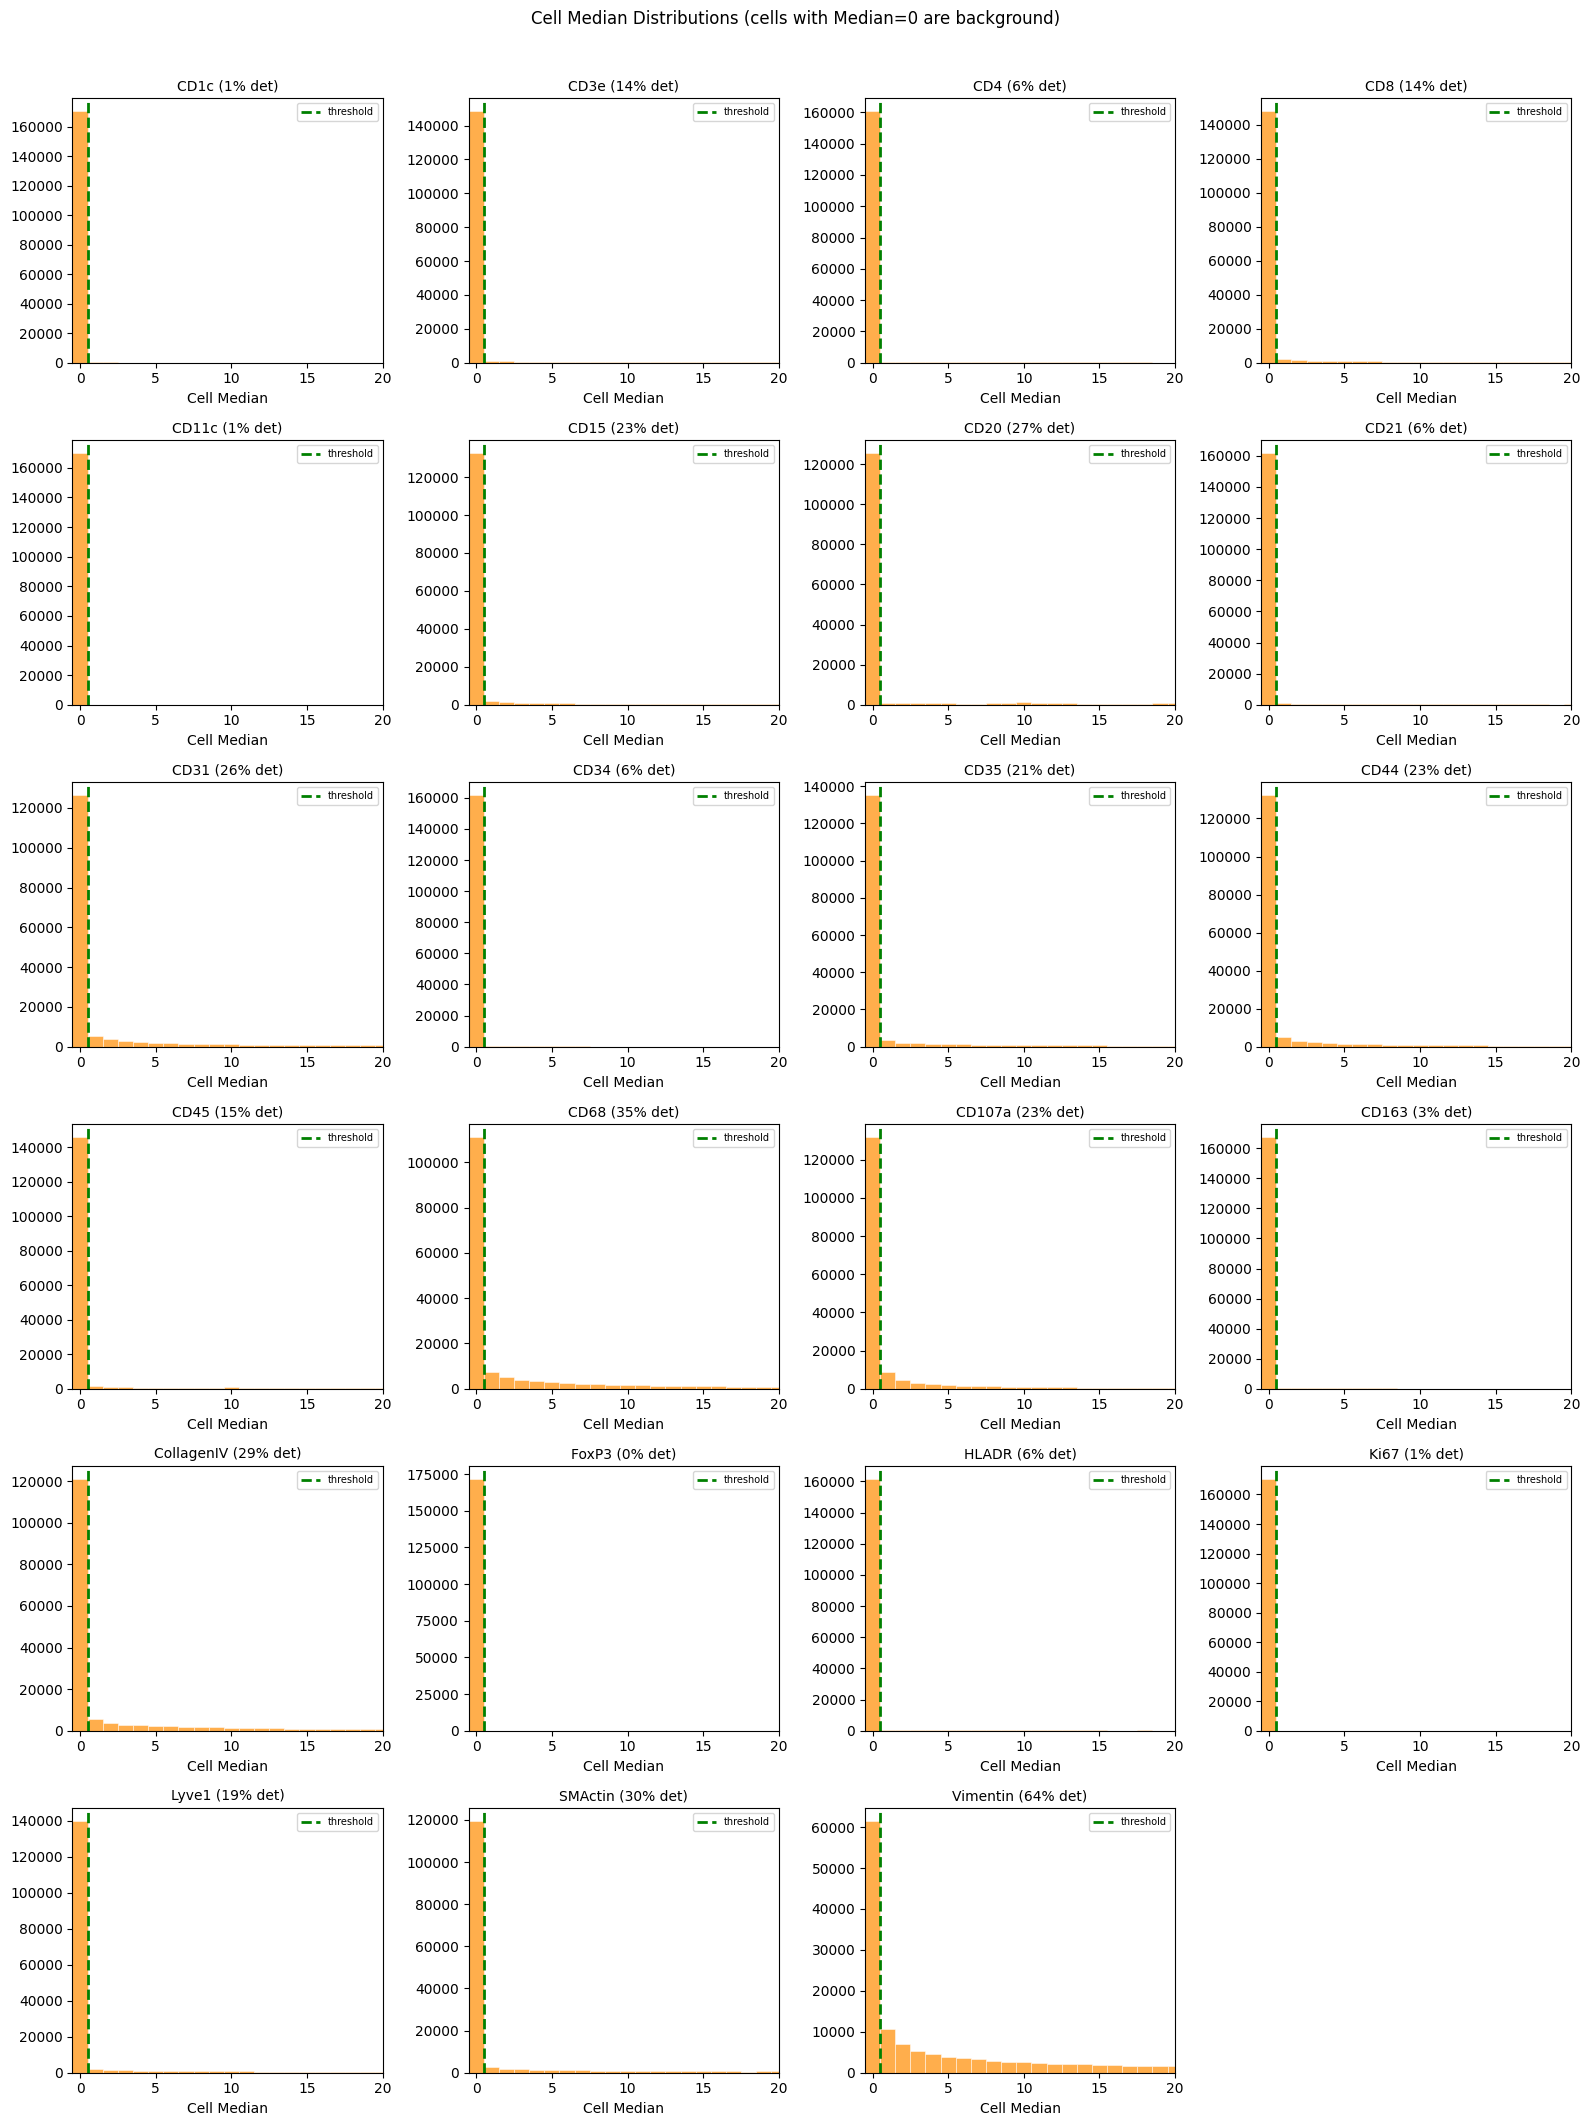


SUMMARY

Background criterion: Cell Median ≤ 0.5

This aligns with histogram matching: background pixels → 0, signal pixels → higher values
A cell with Median=0 has majority background pixels, even if Mean > 0


In [9]:
# Diagnostic: Background detection using Cell Median
# Skip if raw CODEX data not available

if not CODEX_RAW_AVAILABLE:
    print("Skipping: Raw CODEX data not available (run from preprocessing to analyze)")
else:
    # Diagnostic: Background detection using Cell Median
    # After histogram matching, background pixels cluster at 0
    # If a cell's MEDIAN pixel value is 0, the cell is background (not detected)
    
    print("="*70)
    print("PROTEIN BACKGROUND DETECTION (using Cell Median)")
    print("="*70)
    
    protein_names = list(rna_protein_correspondence[:, 1])
    n_features = len(protein_names)
    
    # We need the median values from the original CODEX dataframe
    # Build mapping from protein name to column
    protein_to_median_col = {}
    for prot in protein_names:
        # Find the matching column in codex_df
        for col in codex_df.columns:
            if prot in col and 'Cell:' in col and 'Median' in col:
                protein_to_median_col[prot] = col
                break
    
    print(f"\nAnalyzing {n_features} shared protein features...")
    print(f"Using Cell Median to classify background cells (Median=0 → not detected)")
    
    # Store detection info
    detection_stats = {}
    
    # Create figure: each protein gets a panel with Mean and Median histograms
    plots_per_row = 4
    n_feature_rows = int(np.ceil(n_features / plots_per_row))
    fig, axes = plt.subplots(n_feature_rows, plots_per_row, figsize=(16, 3.5*n_feature_rows))
    if n_feature_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    print(f"\n{'Protein':<12} {'Median=0':>12} {'Median>0':>12} {'% Detected':>12}")
    print("-"*50)
    
    for i in range(n_features):
        prot_name = protein_names[i]
        ax = axes[i]
        
        if prot_name in protein_to_median_col:
            median_col = protein_to_median_col[prot_name]
            median_vals = codex_df[median_col].values
            
            # Get corresponding mean column for comparison
            mean_col = median_col.replace('Median', 'Mean')
            mean_vals = codex_df[mean_col].values if mean_col in codex_df.columns else None
            
            # Classification: Median=0 is background
            is_background = median_vals <= 0.5  # Using 0.5 to catch floating point 0s
            is_detected = ~is_background
            
            n_background = is_background.sum()
            n_detected = is_detected.sum()
            pct_detected = 100 * n_detected / len(median_vals)
            
            detection_stats[prot_name] = {
                'n_background': n_background,
                'n_detected': n_detected,
                'pct_detected': pct_detected
            }
            
            print(f"{prot_name:<12} {n_background:>12,} {n_detected:>12,} {pct_detected:>11.1f}%")
            
            # Plot: Histogram of Median values zoomed to 0-20
            median_zoomed = median_vals[median_vals <= 20]
            ax.hist(median_zoomed, bins=np.arange(-0.5, 21.5, 1), alpha=0.7, 
                    color='darkorange', edgecolor='white', linewidth=0.5)
            ax.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='threshold')
            ax.set_title(f'{prot_name} ({pct_detected:.0f}% det)', fontsize=10)
            ax.set_xlabel('Cell Median')
            ax.set_xlim(left=-0.5, right=20)
            ax.legend(fontsize=7)
        else:
            print(f"{prot_name:<12} {'column not found':>36}")
            ax.set_visible(False)
    
    # Hide unused axes
    for j in range(n_features, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Cell Median Distributions (cells with Median=0 are background)', fontsize=12, y=1.01)
    plt.tight_layout()
    plt.show()
    
    # Summary
    print(f"\n{'='*70}")
    print("SUMMARY")
    print("="*70)
    print(f"\nBackground criterion: Cell Median ≤ 0.5")
    print(f"\nThis aligns with histogram matching: background pixels → 0, signal pixels → higher values")
    print(f"A cell with Median=0 has majority background pixels, even if Mean > 0")

Example feature: CD68 / CD68
  RNA detection: 24.2% (2,266 cells)
  Protein detection (Cell Median > 0): 35.1% (60,401 cells)


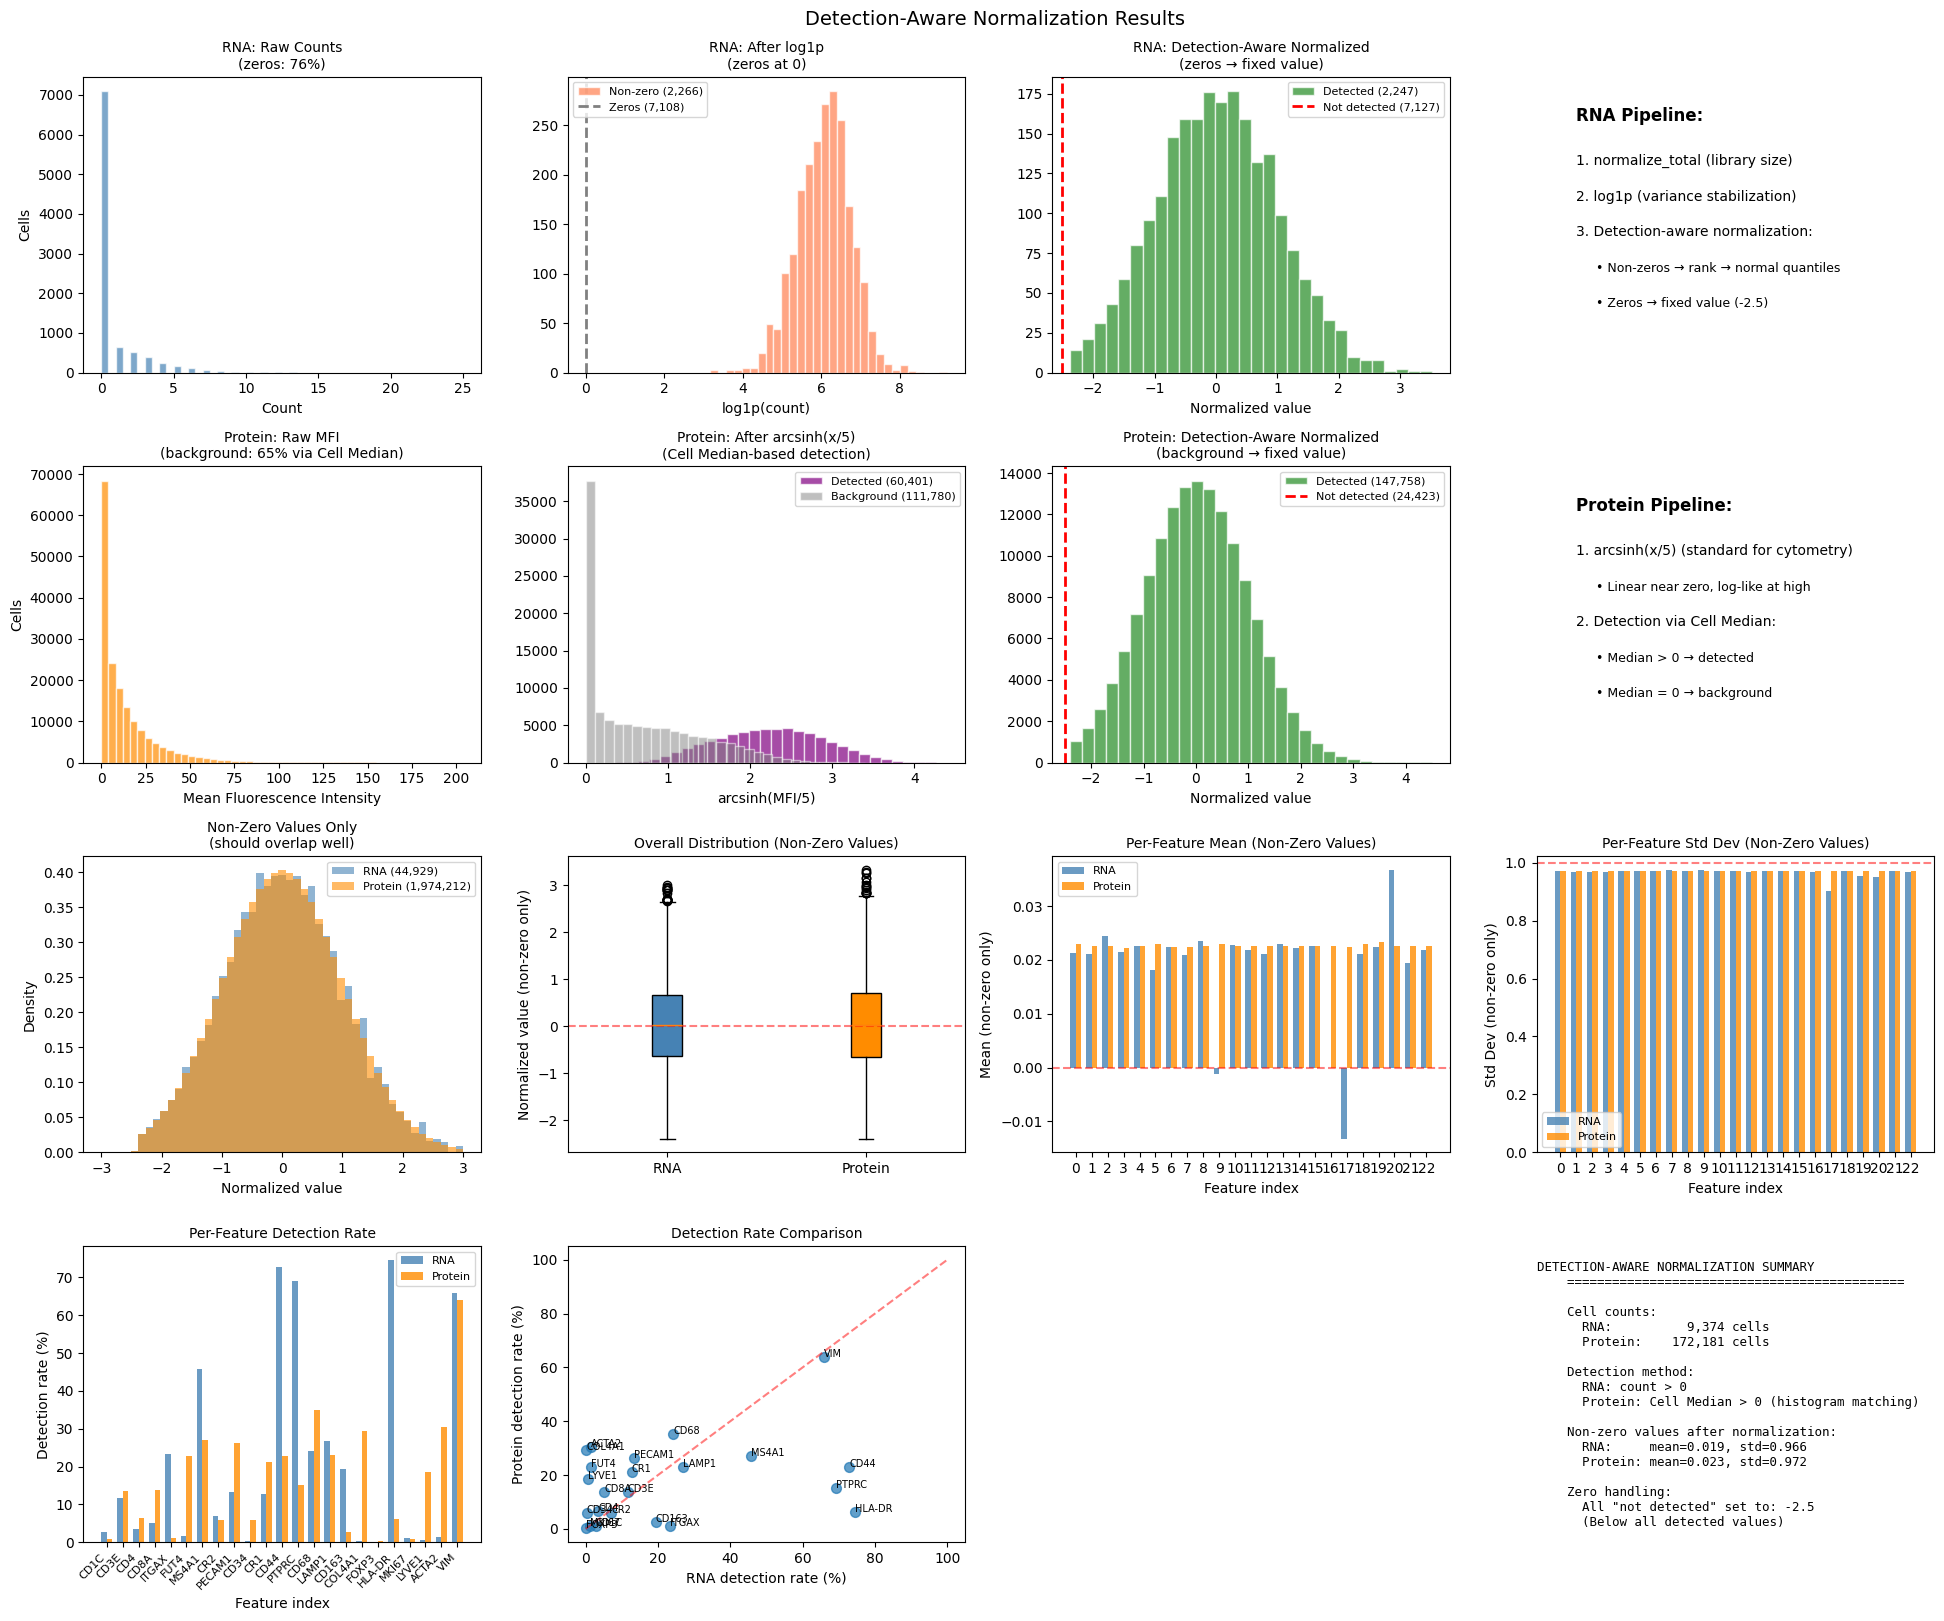


KEY INSIGHT:
RNA detection: count > 0
Protein detection: Cell Median > 0 (accounts for histogram matching)
This ensures 'not detected' is biologically meaningful in both modalities.


In [10]:
# Visualize DETECTION-AWARE normalization
# Skip if raw CODEX data not available

if not CODEX_RAW_AVAILABLE:
    print("Skipping: Raw CODEX data not available (run from preprocessing to analyze)")
else:
    # Visualize DETECTION-AWARE normalization
    # Updated to use Cell Median-based detection for protein data
    
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    
    feature_names = list(rna_protein_correspondence[:, 0])
    protein_names = list(rna_protein_correspondence[:, 1])
    n_features = rna_shared_raw.shape[1]
    
    # Define x_pos and width for bar charts
    x_pos = np.arange(n_features)
    width = 0.35
    
    # Pick a feature with moderate expression
    detection_rates_rna = [(rna_shared_raw[:, i] > 0).mean() for i in range(n_features)]
    good_features = [i for i, d in enumerate(detection_rates_rna) if 0.2 < d < 0.8]
    if good_features:
        best_feat_idx = good_features[len(good_features)//2]
    else:
        best_feat_idx = np.argmax(detection_rates_rna)
    feat_name = feature_names[best_feat_idx]
    prot_name = protein_names[best_feat_idx]
    
    # For protein, use Cell Median-based detection (from cell 26)
    # Build protein detection rates from Cell Median
    protein_to_median_col = {}
    for prot in protein_names:
        for col in codex_df.columns:
            if prot in col and 'Cell:' in col and 'Median' in col:
                protein_to_median_col[prot] = col
                break
    
    # Calculate detection rates: RNA uses >0, Protein uses Cell Median > 0.5
    rna_det_rates = [(rna_shared_raw[:, i] > 0).mean() * 100 for i in range(n_features)]
    prot_det_rates = []
    for i, pname in enumerate(protein_names):
        if pname in protein_to_median_col:
            median_vals = codex_df[protein_to_median_col[pname]].values
            prot_det_rates.append((median_vals > 0.5).mean() * 100)
        else:
            # Fallback to raw >0
            prot_det_rates.append((protein_shared_raw[:, i] > 0).mean() * 100)
    
    rna_det = rna_det_rates[best_feat_idx]
    prot_det = prot_det_rates[best_feat_idx]
    
    print(f"Example feature: {feat_name} / {prot_name}")
    print(f"  RNA detection: {rna_det:.1f}% ({int(rna_det/100 * rna_shared_raw.shape[0]):,} cells)")
    print(f"  Protein detection (Cell Median > 0): {prot_det:.1f}% ({int(prot_det/100 * protein_shared_raw.shape[0]):,} cells)")
    
    ZERO_VALUE = -2.5  # Must match value used in normalization
    
    # ============================================================
    # Row 1: RNA transformation pipeline
    # ============================================================
    ax = axes[0, 0]
    raw_vals = rna_shared_raw[:, best_feat_idx]
    ax.hist(raw_vals, bins=50, alpha=0.7, color='steelblue', edgecolor='white')
    ax.set_title(f'RNA: Raw Counts\n(zeros: {(raw_vals==0).mean()*100:.0f}%)', fontsize=10)
    ax.set_xlabel('Count')
    ax.set_ylabel('Cells')
    
    ax = axes[0, 1]
    log_vals = rna_shared_after_log[:, best_feat_idx]
    zeros = log_vals == 0
    nonzeros = ~zeros
    ax.hist(log_vals[nonzeros], bins=30, alpha=0.7, color='coral', edgecolor='white', label=f'Non-zero ({nonzeros.sum():,})')
    if zeros.sum() > 0:
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=2, label=f'Zeros ({zeros.sum():,})')
    ax.set_title('RNA: After log1p\n(zeros at 0)', fontsize=10)
    ax.set_xlabel('log1p(count)')
    ax.legend(fontsize=8)
    
    ax = axes[0, 2]
    norm_vals = rna_shared_after_scale[:, best_feat_idx]
    nonzero_mask = norm_vals > ZERO_VALUE + 0.1
    ax.hist(norm_vals[nonzero_mask], bins=30, alpha=0.7, color='forestgreen', edgecolor='white', 
            label=f'Detected ({nonzero_mask.sum():,})')
    ax.axvline(x=ZERO_VALUE, color='red', linestyle='--', linewidth=2, 
               label=f'Not detected ({(~nonzero_mask).sum():,})')
    ax.set_title('RNA: Detection-Aware Normalized\n(zeros → fixed value)', fontsize=10)
    ax.set_xlabel('Normalized value')
    ax.legend(fontsize=8)
    
    ax = axes[0, 3]
    ax.axis('off')
    ax.text(0.1, 0.85, 'RNA Pipeline:', fontsize=12, fontweight='bold', transform=ax.transAxes)
    ax.text(0.1, 0.70, '1. normalize_total (library size)', fontsize=10, transform=ax.transAxes)
    ax.text(0.1, 0.58, '2. log1p (variance stabilization)', fontsize=10, transform=ax.transAxes)
    ax.text(0.1, 0.46, '3. Detection-aware normalization:', fontsize=10, transform=ax.transAxes)
    ax.text(0.15, 0.34, '• Non-zeros → rank → normal quantiles', fontsize=9, transform=ax.transAxes)
    ax.text(0.15, 0.22, f'• Zeros → fixed value ({ZERO_VALUE})', fontsize=9, transform=ax.transAxes)
    
    # ============================================================
    # Row 2: Protein transformation pipeline
    # ============================================================
    ax = axes[1, 0]
    raw_vals = protein_shared_raw[:, best_feat_idx]
    # Show Cell Median-based detection
    if prot_name in protein_to_median_col:
        median_vals = codex_df[protein_to_median_col[prot_name]].values
        is_bg = median_vals <= 0.5
        pct_bg = is_bg.mean() * 100
    else:
        pct_bg = (raw_vals == 0).mean() * 100
    ax.hist(raw_vals, bins=50, alpha=0.7, color='darkorange', edgecolor='white')
    ax.set_title(f'Protein: Raw MFI\n(background: {pct_bg:.0f}% via Cell Median)', fontsize=10)
    ax.set_xlabel('Mean Fluorescence Intensity')
    ax.set_ylabel('Cells')
    
    ax = axes[1, 1]
    arcsinh_vals = protein_shared_after_arcsinh[:, best_feat_idx]
    # Use Cell Median for zero classification
    if prot_name in protein_to_median_col:
        median_vals = codex_df[protein_to_median_col[prot_name]].values
        zeros = median_vals <= 0.5
    else:
        zeros = protein_shared_raw[:, best_feat_idx] == 0
    nonzeros = ~zeros
    ax.hist(arcsinh_vals[nonzeros], bins=30, alpha=0.7, color='purple', edgecolor='white', label=f'Detected ({nonzeros.sum():,})')
    if zeros.sum() > 0:
        # Show background cells as a separate histogram
        ax.hist(arcsinh_vals[zeros], bins=30, alpha=0.5, color='gray', edgecolor='white', label=f'Background ({zeros.sum():,})')
    ax.set_title('Protein: After arcsinh(x/5)\n(Cell Median-based detection)', fontsize=10)
    ax.set_xlabel('arcsinh(MFI/5)')
    ax.legend(fontsize=8)
    
    ax = axes[1, 2]
    norm_vals = protein_shared_after[:, best_feat_idx]
    nonzero_mask = norm_vals > ZERO_VALUE + 0.1
    ax.hist(norm_vals[nonzero_mask], bins=30, alpha=0.7, color='forestgreen', edgecolor='white',
            label=f'Detected ({nonzero_mask.sum():,})')
    ax.axvline(x=ZERO_VALUE, color='red', linestyle='--', linewidth=2,
               label=f'Not detected ({(~nonzero_mask).sum():,})')
    ax.set_title('Protein: Detection-Aware Normalized\n(background → fixed value)', fontsize=10)
    ax.set_xlabel('Normalized value')
    ax.legend(fontsize=8)
    
    ax = axes[1, 3]
    ax.axis('off')
    ax.text(0.1, 0.85, 'Protein Pipeline:', fontsize=12, fontweight='bold', transform=ax.transAxes)
    ax.text(0.1, 0.70, '1. arcsinh(x/5) (standard for cytometry)', fontsize=10, transform=ax.transAxes)
    ax.text(0.15, 0.58, '• Linear near zero, log-like at high', fontsize=9, transform=ax.transAxes)
    ax.text(0.1, 0.46, '2. Detection via Cell Median:', fontsize=10, transform=ax.transAxes)
    ax.text(0.15, 0.34, '• Median > 0 → detected', fontsize=9, transform=ax.transAxes)
    ax.text(0.15, 0.22, '• Median = 0 → background', fontsize=9, transform=ax.transAxes)
    
    # ============================================================
    # Row 3: Distribution comparison - NON-ZERO VALUES ONLY
    # ============================================================
    
    # Get non-zero values only
    rna_nonzero = rna_shared_after_scale[rna_shared_after_scale > ZERO_VALUE + 0.1]
    prot_nonzero = protein_shared_after[protein_shared_after > ZERO_VALUE + 0.1]
    
    ax = axes[2, 0]
    bins = np.linspace(-3, 3, 50)
    ax.hist(rna_nonzero, bins=bins, alpha=0.6, density=True, label=f'RNA ({len(rna_nonzero):,})', color='steelblue')
    ax.hist(prot_nonzero, bins=bins, alpha=0.6, density=True, label=f'Protein ({len(prot_nonzero):,})', color='darkorange')
    ax.set_title('Non-Zero Values Only\n(should overlap well)', fontsize=10)
    ax.set_xlabel('Normalized value')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    
    # Box plot of non-zero values
    ax = axes[2, 1]
    rna_sample = rna_nonzero[::max(1, len(rna_nonzero)//5000)]
    prot_sample = prot_nonzero[::max(1, len(prot_nonzero)//5000)]
    bp = ax.boxplot([rna_sample, prot_sample], labels=['RNA', 'Protein'], patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][1].set_facecolor('darkorange')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.set_ylabel('Normalized value (non-zero only)')
    ax.set_title('Overall Distribution (Non-Zero Values)', fontsize=10)
    
    # Per-feature mean of NON-ZERO values (should be ~0)
    ax = axes[2, 2]
    rna_means_nz = []
    prot_means_nz = []
    for i in range(n_features):
        rna_nz = rna_shared_after_scale[:, i][rna_shared_after_scale[:, i] > ZERO_VALUE + 0.1]
        prot_nz = protein_shared_after[:, i][protein_shared_after[:, i] > ZERO_VALUE + 0.1]
        rna_means_nz.append(rna_nz.mean() if len(rna_nz) > 0 else 0)
        prot_means_nz.append(prot_nz.mean() if len(prot_nz) > 0 else 0)
    
    ax.bar(x_pos - width/2, rna_means_nz, width, label='RNA', alpha=0.8, color='steelblue')
    ax.bar(x_pos + width/2, prot_means_nz, width, label='Protein', alpha=0.8, color='darkorange')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Feature index')
    ax.set_ylabel('Mean (non-zero only)')
    ax.set_title('Per-Feature Mean (Non-Zero Values)', fontsize=10)
    ax.legend(fontsize=8)
    ax.set_xticks(x_pos)
    
    # Per-feature std of NON-ZERO values (should be ~1)
    ax = axes[2, 3]
    rna_stds_nz = []
    prot_stds_nz = []
    for i in range(n_features):
        rna_nz = rna_shared_after_scale[:, i][rna_shared_after_scale[:, i] > ZERO_VALUE + 0.1]
        prot_nz = protein_shared_after[:, i][protein_shared_after[:, i] > ZERO_VALUE + 0.1]
        rna_stds_nz.append(rna_nz.std() if len(rna_nz) > 1 else 0)
        prot_stds_nz.append(prot_nz.std() if len(prot_nz) > 1 else 0)
    
    ax.bar(x_pos - width/2, rna_stds_nz, width, label='RNA', alpha=0.8, color='steelblue')
    ax.bar(x_pos + width/2, prot_stds_nz, width, label='Protein', alpha=0.8, color='darkorange')
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Feature index')
    ax.set_ylabel('Std Dev (non-zero only)')
    ax.set_title('Per-Feature Std Dev (Non-Zero Values)', fontsize=10)
    ax.legend(fontsize=8)
    ax.set_xticks(x_pos)
    
    # ============================================================
    # Row 4: Detection rates and summary
    # ============================================================
    
    # Detection rate comparison
    ax = axes[3, 0]
    ax.bar(x_pos - width/2, rna_det_rates, width, label='RNA', alpha=0.8, color='steelblue')
    ax.bar(x_pos + width/2, prot_det_rates, width, label='Protein', alpha=0.8, color='darkorange')
    ax.set_xlabel('Feature index')
    ax.set_ylabel('Detection rate (%)')
    ax.set_title('Per-Feature Detection Rate', fontsize=10)
    ax.legend(fontsize=8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f[:6] for f in feature_names], rotation=45, ha='right', fontsize=8)
    
    # Detection rate scatter
    ax = axes[3, 1]
    ax.scatter(rna_det_rates, prot_det_rates, s=50, alpha=0.7)
    for i, fname in enumerate(feature_names):
        ax.annotate(fname[:6], (rna_det_rates[i], prot_det_rates[i]), fontsize=7)
    ax.plot([0, 100], [0, 100], 'r--', alpha=0.5)
    ax.set_xlabel('RNA detection rate (%)')
    ax.set_ylabel('Protein detection rate (%)')
    ax.set_title('Detection Rate Comparison', fontsize=10)
    
    # Empty placeholder
    ax = axes[3, 2]
    ax.axis('off')
    
    # Summary text
    ax = axes[3, 3]
    ax.axis('off')
    summary = f"""DETECTION-AWARE NORMALIZATION SUMMARY
    {"="*45}
    
    Cell counts:
      RNA:     {rna_shared_raw.shape[0]:>10,} cells
      Protein: {protein_shared_raw.shape[0]:>10,} cells
    
    Detection method:
      RNA: count > 0
      Protein: Cell Median > 0 (histogram matching)
    
    Non-zero values after normalization:
      RNA:     mean={np.mean(rna_means_nz):.3f}, std={np.mean(rna_stds_nz):.3f}
      Protein: mean={np.mean(prot_means_nz):.3f}, std={np.mean(prot_stds_nz):.3f}
    
    Zero handling:
      All "not detected" set to: {ZERO_VALUE}
      (Below all detected values)
    """
    ax.text(0.0, 0.95, summary, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.suptitle('Detection-Aware Normalization Results', fontsize=14, y=1.01)
    plt.show()
    
    print("\n" + "="*70)
    print("KEY INSIGHT:")
    print("="*70)
    print("RNA detection: count > 0")
    print("Protein detection: Cell Median > 0 (accounts for histogram matching)")
    print("This ensures 'not detected' is biologically meaningful in both modalities.")

In [11]:
# Convert to numpy arrays
rna_shared = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared):
    rna_shared = rna_shared.toarray()
    
protein_shared = protein_shared_adata.X.copy()
if sparse.issparse(protein_shared):
    protein_shared = protein_shared.toarray()

# Remove zero-variance features
rna_std = rna_shared.std(axis=0)
prot_std = protein_shared.std(axis=0)
valid_mask = (rna_std > 1e-6) & (prot_std > 1e-6)

if not valid_mask.all():
    print(f"Removing {(~valid_mask).sum()} zero-variance features")
    rna_shared = rna_shared[:, valid_mask]
    protein_shared = protein_shared[:, valid_mask]
    # Update correspondence
    rna_protein_correspondence = rna_protein_correspondence[valid_mask]

print(f"\nFinal shared arrays:")
print(f"  rna_shared: {rna_shared.shape}")
print(f"  protein_shared: {protein_shared.shape}")


Final shared arrays:
  rna_shared: (9374, 23)
  protein_shared: (172181, 23)


In [12]:
# Analyze shared feature quality
print("=" * 60)
print("SHARED FEATURE QUALITY ANALYSIS")
print("=" * 60)

# Get raw counts for analysis (before normalization)
rna_raw_shared = rna_adata[:, rna_protein_correspondence[:, 0]].X
if sparse.issparse(rna_raw_shared):
    rna_raw_shared = rna_raw_shared.toarray()

protein_raw_shared = protein_adata[:, rna_protein_correspondence[:, 1]].X
if sparse.issparse(protein_raw_shared):
    protein_raw_shared = protein_raw_shared.toarray()

# Calculate statistics for each feature
feature_stats = []
for i, (rna_gene, prot_marker) in enumerate(rna_protein_correspondence):
    rna_col = rna_raw_shared[:, i]
    prot_col = protein_raw_shared[:, i]
    
    # % cells expressing
    rna_pct_expressing = (rna_col > 0).sum() / len(rna_col) * 100
    prot_pct_expressing = (prot_col > 0).sum() / len(prot_col) * 100
    
    feature_stats.append({
        'RNA_gene': rna_gene,
        'Protein': prot_marker,
        'RNA_%_expressing': rna_pct_expressing,
        'Prot_%_expressing': prot_pct_expressing,
    })

stats_df = pd.DataFrame(feature_stats)
stats_df = stats_df.sort_values('RNA_%_expressing', ascending=True)

print("\nFeature-by-feature statistics (sorted by RNA detection rate):")
print(stats_df.to_string(index=False))

# Summary
print(f"\n{'='*60}")
print("SUMMARY:")
avg_rna_detection = stats_df['RNA_%_expressing'].mean()
avg_prot_detection = stats_df['Prot_%_expressing'].mean()
print(f"  Average RNA detection rate: {avg_rna_detection:.1f}% of cells")
print(f"  Average Protein detection rate: {avg_prot_detection:.1f}% of cells")

# Warning for sparse features
rare_features = stats_df[stats_df['RNA_%_expressing'] < 10]
if len(rare_features) > 0:
    print(f"\n  NOTE: {len(rare_features)} features detected in <10% of RNA cells")
    print("  These provide weaker signal for matching.")

SHARED FEATURE QUALITY ANALYSIS

Feature-by-feature statistics (sorted by RNA detection rate):
RNA_gene    Protein  RNA_%_expressing  Prot_%_expressing
   FOXP3      FoxP3          0.096010           2.141932
  COL4A1 CollagenIV          0.213356          81.762215
    CD34       CD34          0.277363          31.407647
   LYVE1      Lyve1          0.714743          53.927553
   MKI67       Ki67          1.077448           2.254604
   ACTA2    SMActin          1.461489          84.548237
    FUT4       CD15          1.557499          55.691395
    CD1C       CD1c          2.730958          29.209959
     CD4        CD4          3.509708          20.912296
    CD8A        CD8          5.184553          43.475761
     CR2       CD21          7.030083          15.287401
    CD3E       CD3e         11.627907          39.074578
     CR1       CD35         12.748026          49.011215
  PECAM1       CD31         13.420098          95.282290
   CD163      CD163         19.362065          59.

In [13]:
# Protein active - use all markers (except DAPI)
protein_markers_active = [m for m in protein_adata.var_names if m != 'DAPI']
protein_adata_active = protein_adata[:, protein_markers_active].copy()

# Scale if needed
prot_mean = protein_adata_active.X.mean()
if abs(prot_mean) > 0.1:
    sc.pp.scale(protein_adata_active)
    
print(f"Protein active: {protein_adata_active.shape}")

Protein active: (172181, 25)


In [14]:
# Extract numpy arrays
rna_active = rna_adata.X.copy()
if sparse.issparse(rna_active):
    rna_active = rna_active.toarray()

protein_active = protein_adata_active.X.copy()
if sparse.issparse(protein_active):
    protein_active = protein_active.toarray()

# Remove zero-variance features
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-6]
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-6]

print(f"\nFinal active arrays:")
print(f"  rna_active (HVGs): {rna_active.shape}")
print(f"  protein_active: {protein_active.shape}")


Final active arrays:
  rna_active (HVGs): (9374, 18626)
  protein_active: (172181, 25)


In [15]:
# CRITICAL VALIDATION: Check array dimensions match
print("=" * 50)
print("DIMENSION VALIDATION")
print("=" * 50)
print(f"RNA shared cells:     {rna_shared.shape[0]}")
print(f"RNA active cells:     {rna_active.shape[0]}")
print(f"Protein shared cells: {protein_shared.shape[0]}")
print(f"Protein active cells: {protein_active.shape[0]}")
print()

assert rna_shared.shape[0] == rna_active.shape[0], \
    f"RNA mismatch: shared={rna_shared.shape[0]}, active={rna_active.shape[0]}"
assert protein_shared.shape[0] == protein_active.shape[0], \
    f"Protein mismatch: shared={protein_shared.shape[0]}, active={protein_active.shape[0]}"
assert rna_shared.shape[1] == protein_shared.shape[1], \
    f"Shared feature mismatch: RNA={rna_shared.shape[1]}, Protein={protein_shared.shape[1]}"

print("All dimensions validated!")
print(f"\nIntegrating {rna_active.shape[0]} RNA cells with {protein_active.shape[0]} protein cells")
print(f"Using {rna_shared.shape[1]} shared features for initialization")

DIMENSION VALIDATION
RNA shared cells:     9374
RNA active cells:     9374
Protein shared cells: 172181
Protein active cells: 172181

All dimensions validated!

Integrating 9374 RNA cells with 172181 protein cells
Using 23 shared features for initialization


---
# MARIO Integration

MARIO (Matching And Refinement of Integration Operations) provides:
1. **Matchability test**: Statistical test to validate datasets can be integrated
2. **Interpolation**: Automatic search for optimal weight between overlap and all features
3. **Joint regularized clustering**: Clusters both modalities simultaneously

---

## Step 5: MARIO - Matchability Test (Pre-Integration Diagnostic)

Before running integration, we test whether the two datasets have meaningful correspondence.
MARIO uses random sign flips to create a null distribution and computes p-values.

- **Low p-value** (< 0.05): Datasets are matchable
- **High p-value** (> 0.05): No significant correspondence detected

### Data Validation

Check for and handle NaN/Inf values that may result from normalization of sparse features.

In [16]:
# Check and handle NaN/Inf values before MARIO
# Detection-aware normalization can produce NaN for problematic features

print("Checking for NaN/Inf values in shared arrays...")
print(f"  rna_shared: NaN={np.isnan(rna_shared).sum()}, Inf={np.isinf(rna_shared).sum()}")
print(f"  protein_shared: NaN={np.isnan(protein_shared).sum()}, Inf={np.isinf(protein_shared).sum()}")

# Replace NaN/Inf with 0 (these are likely failed normalizations for sparse features)
if np.isnan(rna_shared).any() or np.isinf(rna_shared).any():
    print("\nCleaning rna_shared...")
    rna_shared = np.nan_to_num(rna_shared, nan=0.0, posinf=0.0, neginf=0.0)
    
if np.isnan(protein_shared).any() or np.isinf(protein_shared).any():
    print("Cleaning protein_shared...")
    protein_shared = np.nan_to_num(protein_shared, nan=0.0, posinf=0.0, neginf=0.0)

# Also check active arrays
print(f"\n  rna_active: NaN={np.isnan(rna_active).sum()}, Inf={np.isinf(rna_active).sum()}")
print(f"  protein_active: NaN={np.isnan(protein_active).sum()}, Inf={np.isinf(protein_active).sum()}")

if np.isnan(rna_active).any() or np.isinf(rna_active).any():
    print("\nCleaning rna_active...")
    rna_active = np.nan_to_num(rna_active, nan=0.0, posinf=0.0, neginf=0.0)
    
if np.isnan(protein_active).any() or np.isinf(protein_active).any():
    print("Cleaning protein_active...")
    protein_active = np.nan_to_num(protein_active, nan=0.0, posinf=0.0, neginf=0.0)

print("\nArrays cleaned and ready for integration.")

Checking for NaN/Inf values in shared arrays...
  rna_shared: NaN=0, Inf=0
  protein_shared: NaN=0, Inf=0

  rna_active: NaN=0, Inf=0
  protein_active: NaN=0, Inf=0

Arrays cleaned and ready for integration.


In [17]:
# Subsample for MARIO (MARIO requires n1 <= n2, and for speed we subsample)
np.random.seed(42)

# MARIO needs RNA (smaller) to be df1 and Protein (larger) to be df2
n_rna_subsample = min(2000, rna_shared.shape[0])
n_prot_subsample = min(10000, protein_shared.shape[0])

rna_idx_subsample = np.random.choice(rna_shared.shape[0], n_rna_subsample, replace=False)
prot_idx_subsample = np.random.choice(protein_shared.shape[0], n_prot_subsample, replace=False)

# Create DataFrames with overlapping column names (required by MARIO)
shared_feature_names = [f"feat_{i}" for i in range(rna_shared.shape[1])]

# Extract subsamples and ensure no NaN values
rna_subsample = rna_shared[rna_idx_subsample].copy()
prot_subsample = protein_shared[prot_idx_subsample].copy()

# Final NaN check on subsamples
rna_subsample = np.nan_to_num(rna_subsample, nan=0.0, posinf=0.0, neginf=0.0)
prot_subsample = np.nan_to_num(prot_subsample, nan=0.0, posinf=0.0, neginf=0.0)

rna_df_mario = pd.DataFrame(rna_subsample, columns=shared_feature_names)
prot_df_mario = pd.DataFrame(prot_subsample, columns=shared_feature_names)

print(f"MARIO subsample sizes:")
print(f"  RNA: {rna_df_mario.shape}")
print(f"  Protein: {prot_df_mario.shape}")
print(f"  NaN in RNA df: {rna_df_mario.isna().sum().sum()}")
print(f"  NaN in Protein df: {prot_df_mario.isna().sum().sum()}")

MARIO subsample sizes:
  RNA: (2000, 23)
  Protein: (10000, 23)
  NaN in RNA df: 0
  NaN in Protein df: 0


In [18]:
# Initialize MARIO
mario = Mario(rna_df_mario, prot_df_mario, normalization=True)

# Specify matching parameters
# n_matched_per_cell: how many protein cells to match with each RNA cell
n_matched = max(1, n_prot_subsample // n_rna_subsample)
mario.specify_matching_params(n_matched_per_cell=n_matched)

print(f"Matching {n_matched} protein cells per RNA cell")

NameError: name 'Mario' is not defined

In [ ]:
# Compute distance using overlapping features
n_ovlp_components = min(15, rna_shared.shape[1] - 1)
dist_ovlp, singular_vals = mario.compute_dist_ovlp(n_components=n_ovlp_components)

print(f"Distance matrix shape: {dist_ovlp.shape}")
print(f"Singular values: {singular_vals[:5]}...")

# Plot singular values
plt.figure(figsize=(8, 4))
plt.plot(singular_vals, 'bo-')
plt.xlabel('Component')
plt.ylabel('Singular Value')
plt.title('MARIO: Singular Values of Stacked Overlap Features')
plt.show()

In [ ]:
# Initial matching using overlap features
print("Finding initial matching using overlap features...")
matching_ovlp = mario.match_cells('ovlp', sparsity=None, mode='auto')

# Count matched cells
n_matched_cells = sum(1 for m in matching_ovlp if len(m) > 0)
print(f"Matched {n_matched_cells}/{len(matching_ovlp)} RNA cells")

In [ ]:
# Add active features (all HVGs) for refined matching
# For MARIO, we need DataFrames with:
# - Overlapping columns (shared features) with same names
# - Non-overlapping columns (active features) with different names

# RNA: shared features + active features
rna_active_subsample = rna_active[rna_idx_subsample].copy()
rna_active_subsample = np.nan_to_num(rna_active_subsample, nan=0.0, posinf=0.0, neginf=0.0)
rna_active_names = [f"rna_feat_{i}" for i in range(rna_active_subsample.shape[1])]

rna_df_full = pd.DataFrame(
    np.hstack([rna_subsample, rna_active_subsample]),
    columns=shared_feature_names + rna_active_names
)

# Protein: shared features + active features
prot_active_subsample = protein_active[prot_idx_subsample].copy()
prot_active_subsample = np.nan_to_num(prot_active_subsample, nan=0.0, posinf=0.0, neginf=0.0)
prot_active_names = [f"prot_feat_{i}" for i in range(prot_active_subsample.shape[1])]

prot_df_full = pd.DataFrame(
    np.hstack([prot_subsample, prot_active_subsample]),
    columns=shared_feature_names + prot_active_names
)

print(f"Full DataFrames for MARIO:")
print(f"  RNA: {rna_df_full.shape} ({len(shared_feature_names)} shared + {len(rna_active_names)} active)")
print(f"  Protein: {prot_df_full.shape} ({len(shared_feature_names)} shared + {len(prot_active_names)} active)")
print(f"  NaN check - RNA: {rna_df_full.isna().sum().sum()}, Protein: {prot_df_full.isna().sum().sum()}")

In [ ]:
# Create new MARIO object with full features
mario_full = Mario(rna_df_full, prot_df_full, normalization=False)
mario_full.specify_matching_params(n_matched_per_cell=n_matched)

# Compute distance using overlap features
_ = mario_full.compute_dist_ovlp(n_components=n_ovlp_components)

# Initial matching
_ = mario_full.match_cells('ovlp', sparsity=None, mode='auto')

# Compute distance using ALL features (CCA refinement)
n_cca_components = min(20, min(rna_df_full.shape[1], prot_df_full.shape[1]) - 1)
dist_all, cancor = mario_full.compute_dist_all('ovlp', n_components=n_cca_components)

print(f"Canonical correlations: {cancor[:5]}...")

# Plot canonical correlations
plt.figure(figsize=(8, 4))
plt.bar(range(len(cancor)), cancor)
plt.xlabel('CCA Component')
plt.ylabel('Canonical Correlation')
plt.title('MARIO: Canonical Correlations (higher = better alignment)')
plt.show()

In [ ]:
# Match using all features
matching_all = mario_full.match_cells('all', sparsity=None, mode='auto')

n_matched_all = sum(1 for m in matching_all if len(m) > 0)
print(f"Matched {n_matched_all}/{len(matching_all)} RNA cells using all features")

In [ ]:
# DIAGNOSTIC: Check canonical correlations before matchability test

print("="*60)
print("MATCHABILITY DIAGNOSTIC")
print("="*60)

# Check the canonical correlations from the existing matching
print("\n1. OBSERVED CANONICAL CORRELATIONS:")
print(f"   From compute_dist_all (stored): {cancor[:5] if 'cancor' in dir() else 'Not computed'}")

# Check data properties
print("\n2. DATA PROPERTIES:")
print(f"   mario_full.df1 shape: {mario_full.df1.shape}")
print(f"   mario_full.df2 shape: {mario_full.df2.shape}")
print(f"   Overlap features: {len(mario_full.ovlp_features)}")

# Check for zero-variance features
df1_std = mario_full.df1.std()
df2_std = mario_full.df2.std()
print(f"\n   df1 zero-variance features: {(df1_std < 1e-10).sum()}")
print(f"   df2 zero-variance features: {(df2_std < 1e-10).sum()}")

# Check data scale
print("\n3. DATA SCALE:")
print(f"   df1 mean: {mario_full.df1.values.mean():.4f}, std: {mario_full.df1.values.std():.4f}")
print(f"   df2 mean: {mario_full.df2.values.mean():.4f}, std: {mario_full.df2.values.std():.4f}")

# CHECK MATCHING - this is critical
print("\n4. MATCHING STATISTICS:")
n_matched_ovlp = sum(1 for m in mario_full.matching['ovlp'] if len(m) > 0)
n_matched_all = sum(1 for m in mario_full.matching['all'] if len(m) > 0)
print(f"   Cells matched (overlap): {n_matched_ovlp} / {mario_full.n1}")
print(f"   Cells matched (all):     {n_matched_all} / {mario_full.n1}")

# Check the aligned data dimensions for CCA
from mario import embed
X_aligned = []
Y_aligned = []
for ii in range(mario_full.n1):
    if len(mario_full.matching['ovlp'][ii]) > 0:
        X_aligned.append(mario_full.df1.iloc[ii, :].values)
        Y_aligned.append(mario_full.df2.iloc[mario_full.matching['ovlp'][ii]].mean(axis=0).values)

X_aligned = np.array(X_aligned)
Y_aligned = np.array(Y_aligned)
print(f"\n5. CCA INPUT DIMENSIONS:")
print(f"   X (RNA) aligned: {X_aligned.shape}")
print(f"   Y (Protein) aligned: {Y_aligned.shape}")
print(f"   Ratio features/samples (RNA): {X_aligned.shape[1]/X_aligned.shape[0]:.1f}")

# THE PROBLEM: CCA with features >> samples gives trivial perfect correlations!
if X_aligned.shape[1] > X_aligned.shape[0]:
    print("\n   ⚠️  WARNING: More features than samples!")
    print("   CCA will overfit and give meaningless correlations of 1.0")
    print("   This is why matchability test returns p=1")

# Test CCA with ONLY overlap features
print("\n6. CCA WITH OVERLAP FEATURES ONLY:")
X_ovlp = mario_full.df1[mario_full.ovlp_features].iloc[[i for i in range(mario_full.n1) if len(mario_full.matching['ovlp'][i]) > 0]].values
Y_ovlp = np.array([mario_full.df2[mario_full.ovlp_features].iloc[mario_full.matching['ovlp'][i]].mean(axis=0).values 
                   for i in range(mario_full.n1) if len(mario_full.matching['ovlp'][i]) > 0])
print(f"   X_ovlp shape: {X_ovlp.shape}")
print(f"   Y_ovlp shape: {Y_ovlp.shape}")

try:
    n_comp = min(5, X_ovlp.shape[1]-1, X_ovlp.shape[0]-1)
    cancor_ovlp_only, _ = embed.get_cancor(X_ovlp, Y_ovlp, n_components=n_comp)
    print(f"   Canonical correlations (overlap only): {cancor_ovlp_only}")
    print(f"   Mean: {np.mean(cancor_ovlp_only):.4f}")
except Exception as e:
    print(f"   Error: {e}")

print("\n" + "="*60)


In [ ]:
# Run matchability test
print("=" * 60)
print("MARIO MATCHABILITY TEST")
print("=" * 60)
print("\nRunning statistical test for dataset matchability...")
print("(This uses random sign flips to create null distribution)")
print()

# CRITICAL FIX: Clean NaN/Inf values in MARIO dataframes before matchability test
# The matchability test internally uses CCA which cannot handle NaN values
print("Cleaning MARIO dataframes for CCA compatibility...")

# Clean df1 (RNA) - aggressive column-by-column approach
mario_full.df1 = mario_full.df1.copy()
for col in mario_full.df1.columns:
    mario_full.df1[col] = np.nan_to_num(mario_full.df1[col].values, nan=0.0, posinf=0.0, neginf=0.0)

# Clean df2 (Protein) - aggressive column-by-column approach
mario_full.df2 = mario_full.df2.copy()
for col in mario_full.df2.columns:
    mario_full.df2[col] = np.nan_to_num(mario_full.df2[col].values, nan=0.0, posinf=0.0, neginf=0.0)

# Verify no NaN/Inf remain
df1_clean = not (np.isnan(mario_full.df1.values).any() or np.isinf(mario_full.df1.values).any())
df2_clean = not (np.isnan(mario_full.df2.values).any() or np.isinf(mario_full.df2.values).any())
print(f"  df1 clean: {df1_clean} (NaN: {np.isnan(mario_full.df1.values).sum()}, Inf: {np.isinf(mario_full.df1.values).sum()})")
print(f"  df2 clean: {df2_clean} (NaN: {np.isnan(mario_full.df2.values).sum()}, Inf: {np.isinf(mario_full.df2.values).sum()})")
assert df1_clean and df2_clean, "Failed to clean NaN/Inf values"

# Ensure both initial (ovlp) and refined (all) matching are complete
print("Verifying initial and refined matching are complete...")

# Check if matching has been done, if not redo it
if not hasattr(mario_full, 'matching_ovlp') or mario_full.matching_ovlp is None:
    print("  Re-running initial matching (overlap features)...")
    mario_full.match_cells('ovlp', sparsity=None, mode='auto')

if not hasattr(mario_full, 'matching_all') or mario_full.matching_all is None:
    print("  Re-running refined matching (all features)...")
    mario_full.match_cells('all', sparsity=None, mode='auto')

print("  Both matchings confirmed. Proceeding with matchability test...\n")

# Note: This can take a few minutes
# Reduce n_sim if it takes too long
pval_ovlp, pval_all = mario_full.matchable(
    n_sim=10,           # Number of simulations (increase for more accuracy)
    top_k=5,            # Use top-k canonical correlations
    flip_prob=0.3,      # Probability of sign flip
    subsample_prop=1,   # Subsample for speed
    verbose=True
)

print(f"\n{'='*60}")
print("MATCHABILITY TEST RESULTS")
print("="*60)
print(f"P-value (overlap features only): {pval_ovlp:.4f}")
print(f"P-value (all features):          {pval_all:.4f}")
print()

if pval_ovlp < 0.05 or pval_all < 0.05:
    print("RESULT: Datasets appear to be MATCHABLE (p < 0.05)")
    print("  The correspondence between modalities is statistically significant.")
else:
    print("RESULT: Datasets may NOT be well-matched (p >= 0.05)")
    print("  Proceed with caution - results may be unreliable.")



## Step 6: MARIO - Interpolation (Optimal Weight Search)

MARIO searches for the optimal weight between:
- Distance from **overlap features only**
- Distance from **all features** (via CCA)

The optimal weight is selected based on canonical correlations.

In [ ]:
# Run interpolation to find optimal weight
print("Searching for optimal interpolation weight...")
print("(Testing weights from 0 to 1)")
print()

best_wt, best_matching = mario_full.interpolate(
    n_wts=10,     # Number of weights to try
    top_k=5,      # Use top-k canonical correlations to evaluate
    verbose=True
)

print(f"\nOptimal weight: {best_wt:.2f}")
print(f"  (0 = use only overlap features, 1 = use only CCA features)")

n_matched_best = sum(1 for m in best_matching if len(m) > 0)
print(f"\nMatched {n_matched_best}/{len(best_matching)} RNA cells with optimal weight")

In [ ]:
# Filter bad matches using joint regularized clustering
print("\nFiltering bad matches using joint regularized clustering...")

n_clusters_filter = min(15, n_rna_subsample // 50)  # Aim for ~50 cells per cluster
n_clusters_filter = max(5, n_clusters_filter)

filtered_matching = mario_full.filter_bad_matches(
    matching='wted',           # Use the interpolated matching
    n_clusters=n_clusters_filter,
    n_components=min(15, n_cca_components),
    bad_prop=0.1,              # Remove ~10% of worst matches
    max_iter=30,
    verbose=True
)

n_matched_filtered = sum(1 for m in filtered_matching if len(m) > 0)
print(f"\nAfter filtering: {n_matched_filtered}/{len(filtered_matching)} RNA cells matched")
print(f"Removed {n_matched_best - n_matched_filtered} bad matches")

In [ ]:
# Optional: KNN matching for softer assignments
knn_matching = mario_full.knn_matching(dist_mat='wted', k=5)

print(f"KNN matching: each RNA cell matched to {5} nearest protein cells")

In [ ]:
# Compute CCA embedding for visualization
from mario import embed

# Align the datasets using the filtered matching
X_aligned = []
Y_aligned = []
matched_rna_indices_mario = []
matched_prot_indices_mario = []

for i, matches in enumerate(filtered_matching):
    if len(matches) > 0:
        X_aligned.append(rna_df_full.iloc[i].values)
        # Average the matched protein cells
        Y_aligned.append(prot_df_full.iloc[matches].mean(axis=0).values)
        matched_rna_indices_mario.append(rna_idx_subsample[i])
        matched_prot_indices_mario.append(prot_idx_subsample[matches[0]])  # Take first match

X_aligned = np.array(X_aligned)
Y_aligned = np.array(Y_aligned)

print(f"Aligned arrays: RNA {X_aligned.shape}, Protein {Y_aligned.shape}")

# Fit CCA for embedding
embed_dim = min(20, X_aligned.shape[1], Y_aligned.shape[1])
cancor_embed, cca = embed.get_cancor(X_aligned, Y_aligned, n_components=embed_dim)

# Get CCA scores
rna_cca_mario, prot_cca_mario = cca.transform(X_aligned, Y_aligned)

print(f"MARIO CCA embedding: {rna_cca_mario.shape}")

In [ ]:
# Visualize MARIO results
from sklearn.manifold import TSNE

# Combine embeddings
combined_mario = np.vstack([rna_cca_mario, prot_cca_mario])
labels_mario = ['RNA'] * len(rna_cca_mario) + ['Protein'] * len(prot_cca_mario)

# Run t-SNE (faster than UMAP for small datasets)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embedding_2d = tsne.fit_transform(combined_mario[:, :10])  # Use first 10 CCA components

# Plot
plt.figure(figsize=(10, 8))
for label in ['RNA', 'Protein']:
    mask = np.array(labels_mario) == label
    plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], 
                label=label, alpha=0.5, s=10)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('MARIO: Joint Embedding (t-SNE of CCA scores)')
plt.legend()
plt.show()

---
# MaxFuse Integration

MaxFuse uses:
1. Graph-based smoothing for noise reduction
2. Iterative CCA refinement
3. Pivot-based propagation for scalability

---

## Step 7: MaxFuse Integration

MaxFuse performs the integration in several stages:
1. Split data into batches for scalability
2. Construct k-NN graphs and cluster cells
3. Find initial pivot matches using shared features
4. Refine pivots using CCA on all features
5. Propagate matching to all cells

In [ ]:
# Create Fusor - let MaxFuse cluster automatically
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,  # Let MaxFuse cluster
    labels2=None,
    method='centroid_shrinkage'
)

In [ ]:
# Calculate appropriate batching parameters
n_rna = rna_active.shape[0]
n_prot = protein_active.shape[0]
ratio = n_prot / n_rna

print(f"RNA cells: {n_rna}")
print(f"Protein cells: {n_prot}")
print(f"Ratio (protein/RNA): {ratio:.1f}")

# Batching parameters
max_outward = min(8000, n_rna)
matching_ratio = max(10, int(ratio) + 5)  # Adjusted for data ratio
metacell_sz = 2  # Metacell aggregation helps with noise

print(f"\nBatching parameters:")
print(f"  max_outward_size: {max_outward}")
print(f"  matching_ratio: {matching_ratio}")
print(f"  metacell_size: {metacell_sz}")

In [ ]:
fusor.split_into_batches(
    max_outward_size=max_outward,
    matching_ratio=matching_ratio,
    metacell_size=metacell_sz,
    verbose=True
)

In [ ]:
# Plot singular values to determine SVD components
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plt.sca(axes[0])
fusor.plot_singular_values(target='active_arr1', n_components=50)
axes[0].set_title('RNA Active - Singular Values')

plt.sca(axes[1])
fusor.plot_singular_values(target='active_arr2', n_components=min(23, protein_active.shape[1]-1))
axes[1].set_title('Protein Active - Singular Values')

plt.tight_layout()
plt.show()

In [ ]:
# Set SVD components based on data dimensions
n_prot_features = protein_active.shape[1]
n_rna_features = rna_active.shape[1]
n_shared = rna_shared.shape[1]

svd_comp1_graph = min(40, n_rna_features - 1)
svd_comp2_graph = min(15, n_prot_features - 1)

print(f"Graph construction SVD components:")
print(f"  RNA: {svd_comp1_graph}")
print(f"  Protein: {svd_comp2_graph}")

In [ ]:
# Construct graphs with automatic clustering
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=svd_comp1_graph,
    svd_components2=svd_comp2_graph,
    resolution1=2.0,   # Higher resolution = more clusters = finer smoothing
    resolution2=2.0,
    resolution_tol=0.1,
    leiden_runs=1,
    verbose=True
)

In [ ]:
# Find initial pivots with smoothing for weak linkage
svd_shared1 = min(25, n_shared - 1)
svd_shared2 = min(20, n_shared - 1)
print(f"Using {svd_shared1}/{svd_shared2} SVD components for shared features")

fusor.find_initial_pivots(
    wt1=0.3,  # Smoothing weight
    wt2=0.3,
    svd_components1=svd_shared1,
    svd_components2=svd_shared2,
    verbose=True
)

In [ ]:
# Check canonical correlations
cca_comp_check = min(15, n_prot_features - 1)
fusor.plot_canonical_correlations(
    svd_components1=min(30, n_rna_features - 1),
    svd_components2=None,
    cca_components=cca_comp_check
)

In [ ]:
# Refine pivots using CCA
cca_components = min(25, n_prot_features - 1)

fusor.refine_pivots(
    wt1=0.3,
    wt2=0.3,
    svd_components1=min(40, n_rna_features - 1),
    svd_components2=None,  # Keep all protein features
    cca_components=cca_components,
    n_iters=1,
    filter_prop=0.0,
    verbose=True
)

In [ ]:
# Filter bad pivots
fusor.filter_bad_matches(
    target='pivot',
    filter_prop=0.5,  # Remove bottom 50%
    verbose=True
)

In [ ]:
# Propagate to all cells
fusor.propagate(
    svd_components1=min(40, n_rna_features - 1),
    svd_components2=None,
    wt1=0.7,
    wt2=0.7,
    verbose=True
)

In [ ]:
# Filter propagated matches
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0.3,  # Remove bottom 30%
    verbose=True
)

In [ ]:
# Get full matching
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

print(f"\nMaxFuse Full matching results:")
print(f"  Total matches: {len(full_matching[0])}")
print(f"  Unique RNA cells: {len(np.unique(full_matching[0]))}")
print(f"  Unique Protein cells: {len(np.unique(full_matching[1]))}")
print(f"  Score range: [{min(full_matching[2]):.3f}, {max(full_matching[2]):.3f}]")

## Save Integration Results

Save integration outputs for use in subsequent visualization notebooks.

In [ ]:
# Save integration results to results directory
import os
import pickle
from datetime import datetime

# Create results directory
results_dir = 'results/2_integration'
os.makedirs(results_dir, exist_ok=True)

# Save matching results
matching_data = {
    'rna_indices': full_matching[0],
    'protein_indices': full_matching[1],
    'scores': full_matching[2]
}
with open(f'{results_dir}/maxfuse_matching.pkl', 'wb') as f:
    pickle.dump(matching_data, f)
print(f"Saved MaxFuse matching: {len(full_matching[0])} matches")

# Save as CSV for easy inspection
matching_df = pd.DataFrame({
    'rna_idx': full_matching[0],
    'protein_idx': full_matching[1],
    'score': full_matching[2]
})
matching_df.to_csv(f'{results_dir}/maxfuse_matching.csv', index=False)

# Save normalized arrays used for integration
np.save(f'{results_dir}/rna_shared.npy', rna_shared)
np.save(f'{results_dir}/rna_active.npy', rna_active)
np.save(f'{results_dir}/protein_shared.npy', protein_shared)
np.save(f'{results_dir}/protein_active.npy', protein_active)
print(f"Saved normalized arrays")

# Save correspondence table
correspondence_df = pd.DataFrame(unique_pairs, columns=['rna_gene', 'protein_marker'])
correspondence_df.to_csv(f'{results_dir}/correspondence.csv', index=False)

# Save integration parameters
n_shared = rna_shared.shape[1]
integration_params = {
    'timestamp': datetime.now().isoformat(),
    'fusor_params': {
        'max_outward_size': max_outward,
        'matching_ratio': matching_ratio,
        'smoothing_method': 'graph_smoothing',
        'n_shared_features': n_shared,
        'cca_components': cca_components
    },
    'data_shapes': {
        'rna_cells': rna_active.shape[0],
        'protein_cells': protein_active.shape[0],
        'rna_active_features': rna_active.shape[1],
        'protein_active_features': protein_active.shape[1],
        'shared_features': n_shared
    },
    'matching_stats': {
        'total_matches': len(full_matching[0]),
        'unique_rna_matched': len(np.unique(full_matching[0])),
        'unique_protein_matched': len(np.unique(full_matching[1])),
        'mean_score': float(np.mean(full_matching[2]))
    }
}
with open(f'{results_dir}/integration_params.json', 'w') as f:
    json.dump(integration_params, f, indent=2)

print(f"\nAll outputs saved to {results_dir}/")
print(f"  - maxfuse_matching.pkl (pickle)")
print(f"  - maxfuse_matching.csv")
print(f"  - rna_shared.npy, rna_active.npy")
print(f"  - protein_shared.npy, protein_active.npy")
print(f"  - correspondence.csv")
print(f"  - integration_params.json")
print(f"\nRun 3_visualization.ipynb next.")